# HEP Benchmark Query Q7

This follows the [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
and the article [Evaluating Query Languages and Systems for High-Energy Physics Data](https://arxiv.org/abs/2104.12615)
and provides implementations of the benchmark tasks using Apache Spark.

The workload and data:
  - Benchmark jobs are implemented according to the [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
  - The input data is a series of events from CMS opendata
  - The job output is typically a histogram 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
February, 2022


In [ ]:
# Download the data if not yet available locally

# Download the reduced data set (2 GB)
! wget -r -np -R "index.html*" -e robots=off https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012B_SingleMu_sample.parquet/

# This downloads the full dataset (16 GB)
# ! wget -r -np -R "index.html*" -e robots=off https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012B_SingleMu.parquet/

In [14]:
# Install sparkhistogram
! pip install sparkhistogram

from sparkhistogram import computeHistogram

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity

# The use of findspark is optional
# import findspark
# findspark.init("/home/luca/Spark/spark-3.5.1-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("HEP benchmark")
         .master("local[4]")
         .config("spark.driver.memory", "4g")
         .getOrCreate()
        )


In [2]:
# Read data for the benchmark tasks
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

path = "sparkdltrigger.web.cern.ch/sparkdltrigger/"
input_data = "Run2012B_SingleMu_sample.parquet"

# use this if you downloaded the full dataset
# input_data = "Run2012B_SingleMu.parquet"

df_events = spark.read.parquet(path + input_data)

df_events.printSchema()

print(f"Number of events: {df_events.count()}")

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: long (nullable = true)
 |-- event: long (nullable = true)
 |-- HLT_IsoMu24_eta2p1: boolean (nullable = true)
 |-- HLT_IsoMu24: boolean (nullable = true)
 |-- HLT_IsoMu17_eta2p1_LooseIsoPFTau20: boolean (nullable = true)
 |-- PV_npvs: integer (nullable = true)
 |-- PV_x: float (nullable = true)
 |-- PV_y: float (nullable = true)
 |-- PV_z: float (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- 

# Q7 - Solution 1/2: Use the explode function
Plot the scalar sum in each event of the 𝑝𝑇 of the jets with
$𝑝_𝑇$ > 30 GeV that are not within 0.4 in Δ𝑅 of any light
lepton (i.e., electron or muon) with $𝑝_𝑇$ > 10 GeV.


In [3]:
import math
pi = str(math.pi)
pi

'3.141592653589793'

In [6]:
# Select and packs the components for
# Jet_pt, which contains arrays of jet measurements
# Electrons and Muons

df_events_q7 = df_events.selectExpr("event",
                                    "arrays_zip(Jet_pt, Jet_eta, Jet_phi) as Jet",
                                    "arrays_zip(Electron_pt, Electron_eta, Electron_phi) as Electron",
                                    "arrays_zip(Muon_pt, Muon_eta, Muon_phi) as Muon")
df_events_q7.printSchema()


root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |-- Electron: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Electron_pt: float (nullable = true)
 |    |    |-- Electron_eta: float (nullable = true)
 |    |    |-- Electron_phi: float (nullable = true)
 |-- Muon: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Muon_pt: float (nullable = true)
 |    |    |-- Muon_eta: float (nullable = true)
 |    |    |-- Muon_phi: float (nullable = true)



In [7]:
# Explode the Jet values (from array elements ot table rows)

df_events_q7_w1 = df_events_q7.selectExpr("event", "explode(Jet) as j", "Electron", "Muon")

df_events_q7_w1.show(5, False)

+---------+------------------------------------+--------+--------------------------------------+
|event    |j                                   |Electron|Muon                                  |
+---------+------------------------------------+--------+--------------------------------------+
|174546626|{28.03698, -2.573142, -0.0039507723}|[]      |[{41.292233, -0.61345077, 0.91725355}]|
|174546626|{20.425129, -0.6191127, 2.44285}    |[]      |[{41.292233, -0.61345077, 0.91725355}]|
|174546626|{18.646175, 2.5256636, 1.2553711}   |[]      |[{41.292233, -0.61345077, 0.91725355}]|
|174546626|{17.995762, -3.8685246, 1.146259}   |[]      |[{41.292233, -0.61345077, 0.91725355}]|
|174546626|{17.04349, -3.4595842, 2.2116172}   |[]      |[{41.292233, -0.61345077, 0.91725355}]|
+---------+------------------------------------+--------+--------------------------------------+
only showing top 5 rows



In [8]:
# This is not a real UDF, but just a string function that implements
# the dimuon mass formula

def DeltaR_macro(p0_eta: str, p0_phi: str, p1_eta: str, p1_phi: str) -> str:
    result = f"sqrt( pow( ({p0_eta} - {p1_eta}), 2) + pow( ({p0_phi} - {p1_phi} + {pi}) % (2 * {pi}) - {pi}, 2) )"
    return result

In [9]:
# example of use:

f"{DeltaR_macro('j.Jet_eta', 'e.Electron_eta', 'j.Jet_phi', 'e.Electron_phi')}"

'sqrt( pow( (j.Jet_eta - j.Jet_phi), 2) + pow( (e.Electron_eta - e.Electron_phi + 3.141592653589793) % (2 * 3.141592653589793) - 3.141592653589793, 2) )'

In [10]:
# Filter the events
# - only Jets with pt > 30 GeV
#  not in .4 in Δ𝑅 of any light lepton (i.e., electron or muon)
# additional filter on leptons: 𝑝𝑇 > 10 GeV

df_events_q7_w2 = df_events_q7_w1.filter(f"""
j.Jet_pt > 30
and not exists( Electron, e -> e.Electron_pt > 10
                and {DeltaR_macro('j.Jet_eta', 'e.Electron_eta', 'j.Jet_phi', 'e.Electron_phi')} < 0.4
              )                    
and not exists( Muon, mu -> mu.Muon_pt > 10
                and {DeltaR_macro('j.Jet_eta', 'mu.Muon_eta', 'j.Jet_phi', 'mu.Muon_phi')} < 0.4
              )
""")

In [11]:
# Compute the sum of Jet_pt per event

from pyspark.sql.functions import sum

q7 = df_events_q7_w2.groupBy("event").agg(sum("j.Jet_pt").alias("summed_jet_pt"))


In [15]:
# Compute the histogram of Jet_pt
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 15
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

# Use the helper function computeHistogram in the package sparkhistogram
# The result is a histogram with (summed_jet_pt) bin values and event counts foreach bin
histogram_data = computeHistogram(q7, "summed_jet_pt", min_val, max_val, num_bins) 


In [16]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 355 ms, sys: 42.3 ms, total: 397 ms
Wall time: 11.3 s


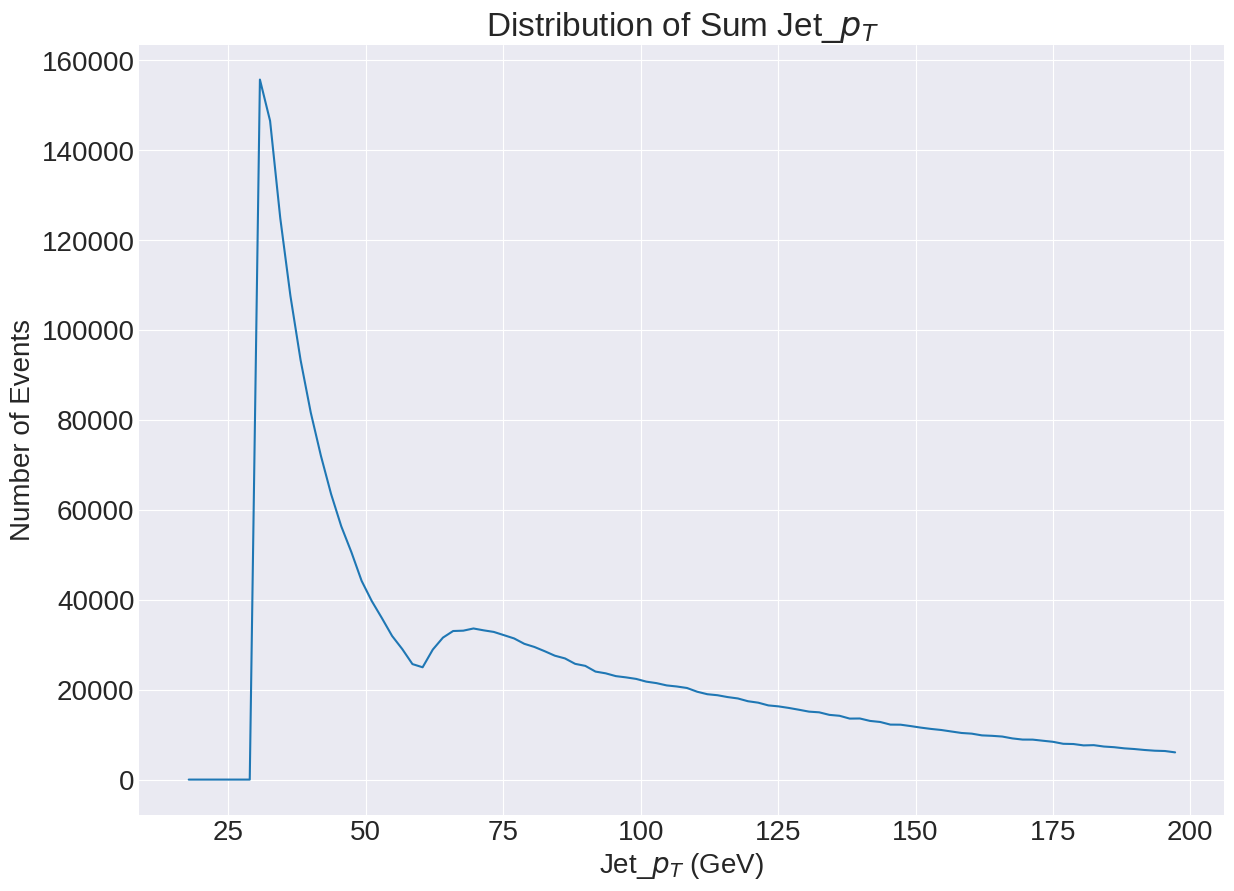

In [18]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet_$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Sum Jet_$p_T$ ")

plt.show()

# Q7 - Solution 2: Use Spark higher order functions for array processing
Plot the scalar sum in each event of the 𝑝𝑇 of the jets with
$𝑝_𝑇$ > 30 GeV that are not within 0.4 in Δ𝑅 of any light
lepton (i.e., electron or muon) with $𝑝_𝑇$ > 10 GeV.


In [19]:
# Select and packs the components for
# Jet_pt, which contains arrays of jet measurements
# Electrons and Muons

df_events_q7 = df_events.selectExpr("event",
                                    "arrays_zip(Jet_pt, Jet_eta, Jet_phi) as Jet",
                                    "arrays_zip(Electron_pt, Electron_eta, Electron_phi) as Electron",
                                    "arrays_zip(Muon_pt, Muon_eta, Muon_phi) as Muon")
df_events_q7.printSchema()
#df_events_q7.show(10, False)

root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |-- Electron: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Electron_pt: float (nullable = true)
 |    |    |-- Electron_eta: float (nullable = true)
 |    |    |-- Electron_phi: float (nullable = true)
 |-- Muon: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Muon_pt: float (nullable = true)
 |    |    |-- Muon_eta: float (nullable = true)
 |    |    |-- Muon_phi: float (nullable = true)



In [20]:
# This is not a real UDF, but just a string function that implements
# the dimuon mass formula

def DeltaR_macro(p0_eta: str, p0_phi: str, p1_eta: str, p1_phi: str) -> str:
    result = f"sqrt( pow( ({p0_eta} - {p1_eta}), 2) + pow( ({p0_phi} - {p1_phi} + {pi}) % (2 * {pi}) - {pi}, 2) )"
    return result

In [21]:
# Filter the events
# - only Jets with pt > 30 GeV
#  not in .4 in Δ𝑅 of any light lepton (i.e., electron or muon)
# additional filter on leptons: 𝑝𝑇 > 10 GeV

q7_filtered = df_events_q7.selectExpr("event", f"""
filter(Jet, j -> j.Jet_pt > 30
       and not exists( Electron, e -> e.Electron_pt > 10
                       and {DeltaR_macro('j.Jet_eta', 'e.Electron_eta', 'j.Jet_phi', 'e.Electron_phi')} < 0.4
                     )
       and not exists( Muon, mu -> mu.Muon_pt > 10
                       and {DeltaR_macro('j.Jet_eta', 'mu.Muon_eta', 'j.Jet_phi', 'mu.Muon_phi')} < 0.4
                     )
) Jet_Filtered
""")

In [22]:
# Compute the sum of Jet_pt 
# This uses Spark's higher order function for array processing
# The sum is pushed as a reduce operation into Jet_pt arrays

q7 = q7_filtered.selectExpr("event", "aggregate(Jet_Filtered.Jet_pt, 0.0f, (acc, j) -> acc + j) as summed_jet_pt").filter("summed_jet_pt>0.0")

q7.printSchema()
q7.show(5, False)

root
 |-- event: long (nullable = true)
 |-- summed_jet_pt: float (nullable = true)

+---------+-------------+
|event    |summed_jet_pt|
+---------+-------------+
|174634270|44.719715    |
|174663998|69.16882     |
|174711732|218.39832    |
|174768173|30.949333    |
|174913239|205.90196    |
+---------+-------------+
only showing top 5 rows



In [23]:
# Compute the histogram of Jet_pt
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 15
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

# Use the helper function computeHistogram in the package sparkhistogram
# The result is a histogram with (summed_jet_pt) bin values and event counts foreach bin
histogram_data = computeHistogram(q7, "summed_jet_pt", min_val, max_val, num_bins) 


In [24]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 20.9 ms, sys: 6.13 ms, total: 27 ms
Wall time: 17.8 s


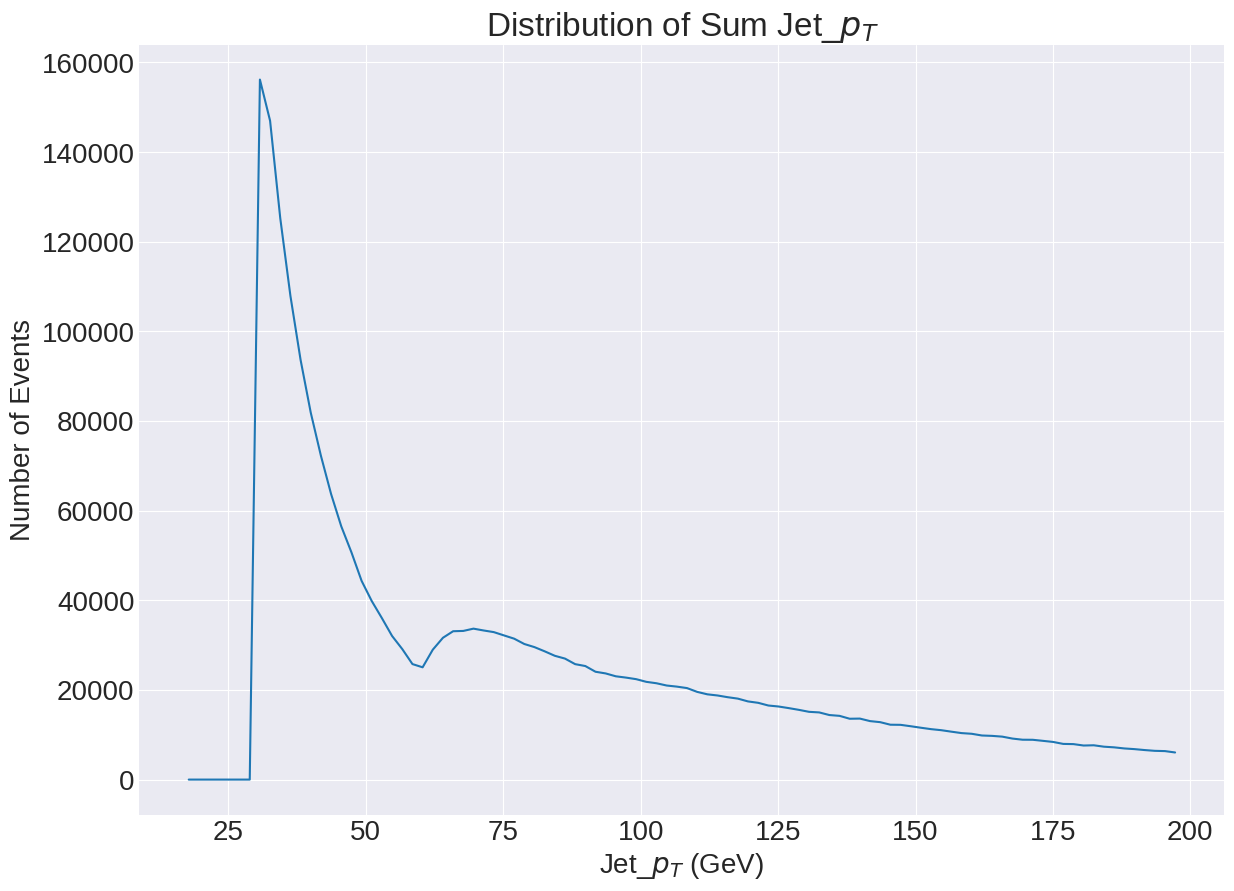

In [25]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet_$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Sum Jet_$p_T$ ")

plt.show()

In [26]:
spark.stop()